In [82]:
import pandas as pd
import string
import numpy as np

Strategy for matching and finding the same power plants:
* equal join on: "Recipient ISO-3", "primary_fuel" (if it is there)
* fuzzy join:
    * "installed_capacity"
    * "additional_info"
    * city and province

In [83]:
cofi_pp_columns = ['country_iso3c', "primary_fuel", "installed_capacity", "power_plant_name", "city", "province"]
aiddata_pp_columns = ["Recipient ISO-3", "primary_fuel", "installed_capacity", "additional_info", "city", "province"]

Strategy for matching and finding the same investment info:
* match first for the power plant
* fuzzy join:
    * "Commitment Year"
    * "Funding Agencies" and "Co-financing Agencies"
    * "Amount (Constant USD 2021)"
    * "installed_capacity"
    * "additional_info"


In [84]:
def preprocess_text(text, remove_punctuation = False):
  # Implement your preprocessing logic here (e.g., lowercase conversion)

    new_string = text.lower()

    if remove_punctuation is True:
        # Create a translation table
        translator = str.maketrans('', '', string.punctuation)
        # Remove punctuation
        new_string = new_string.translate(translator)

    return new_string

## 1. Load data

In [85]:
aid = pd.read_excel("Cleaned Data/AidData.xlsx")
# aid = aid.drop(columns=["GPT answer - capacity and fuel", "GPT answer - city and province", 'encoding Description', 'Present', 'GPT answer',
#       'CPG answer - capacity and fuel', 'capcity', "Amount (Constant USD 2021)"	,"Adjusted Amount (Constant USD 2021)"])
aid.head()

,Title,AidData Record ID,Recipient ISO-3,Commitment Year,Funding Agencies,Co-financing Agencies,Amount (Nominal USD),Amount (Constant USD 2021),Adjusted Amount (Constant USD 2021),Flow Type,...,Geographic Level of Precision Available,ADM1 Level Available,ADM2 Level Available,Geospatial Feature Available,Source Quality Score,Data Completeness Score,Implementation Detail Score,Loan Detail Score,Present,GPT answer
0,ICBC provides $825 million export credit facil...,40,BWA,2009,Industrial and Commercial Bank of China (ICBC),African Development Bank (AfDB) (ADB) (BAD)|St...,8.250486e+08,1.239231e+09,1.239231e+09,Loan,...,Precise,Yes,Yes,Yes,5.0,5.0,5.0,5.0,NaN,* City: Palapye\n* Province: N/A
1,China Eximbank provides $70 million government...,85,GAB,2008,Export-Import Bank of China (China Eximbank),NaN,7.000000e+07,1.067210e+08,1.067210e+08,Loan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,China Eximbank provides RMB 1.08 billion selle...,158,SDN,2001,Export-Import Bank of China (China Eximbank),NaN,1.304797e+08,3.280962e+08,3.280962e+08,Loan,...,Precise,Yes,Yes,Yes,5.0,5.0,5.0,2.0,NaN,* City: El-Gaili\n* Province: N/A
3,China Eximbank pledges $297.8 million loan for...,173,NGA,2005,Export-Import Bank of China (China Eximbank),NaN,2.977500e+08,6.461870e+08,6.461870e+08,Loan,...,NaN,NaN,NaN,NaN,5.0,4.0,NaN,NaN,NaN,* City: Papalanto\n* Province: N/A
4,China Eximbank provides $608 million loan for ...,178,SDN,2003,Export-Import Bank of China (China Eximbank),Abu Dhabi Development Fund |Arab Fund for Econ...,6.080000e+08,1.481127e+09,1.481127e+09,Loan,...,Precise,Yes,Yes,Yes,5.0,5.0,4.0,5.0,NaN,* City: Merowe Town\n* Province: Northern Sudan


In [86]:
aid.tail()

,Title,AidData Record ID,Recipient ISO-3,Commitment Year,Funding Agencies,Co-financing Agencies,Amount (Nominal USD),Amount (Constant USD 2021),Adjusted Amount (Constant USD 2021),Flow Type,...,Geographic Level of Precision Available,ADM1 Level Available,ADM2 Level Available,Geospatial Feature Available,Source Quality Score,Data Completeness Score,Implementation Detail Score,Loan Detail Score,Present,GPT answer
653,China Development Bank contributes to $1.78 bi...,98814,BGD,2018,China Development Bank (CDB),Agricultural Bank of China (ABC)|Bank of China...,296666666.7,3.233221e+08,3.233221e+08,Loan,...,NaN,NaN,NaN,NaN,5.0,5.0,5.0,3.0,The purpose of the project was to construct a ...,* City: Banskhali\n* Province: Chittagong Divi...
654,Agricultural Bank of China contributes to $1.7...,98815,BGD,2018,Agricultural Bank of China (ABC),Bank of China (BOC)|China Construction Bank Co...,296666666.7,3.233221e+08,3.233221e+08,Loan,...,NaN,NaN,NaN,NaN,5.0,5.0,5.0,3.0,The purpose of the project was to construct a ...,* City: Banskhali\n* Province: Chittagong Divi...
655,ICBC contributes to a $75 million syndicated l...,98823,IDN,2020,Industrial and Commercial Bank of China (ICBC),China Development Bank (CDB),37500000.0,4.188139e+07,4.188139e+07,Loan,...,NaN,NaN,NaN,NaN,5.0,3.0,NaN,2.0,NaN,* City: N/A\n* Province: Sulawesi Province
656,ICBC contributes to $1.416 billion syndicated ...,98851,PAK,2017,Industrial and Commercial Bank of China (ICBC),Al Jomaih Group|China Gezhouba Group Company L...,708100000.0,8.159706e+08,8.159706e+08,Loan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
657,ICBC contributes $15 million to $219.5 million...,98852,ARG,2017,Industrial and Commercial Bank of China (ICBC),Bancaribe|Banco de Galicia y Buenos Aires S.A....,15000000.0,1.728507e+07,1.728507e+07,Loan,...,NaN,NaN,NaN,NaN,5.0,5.0,4.0,4.0,NaN,* City: Central El Bracho\n* Province: Tucumán...


In [87]:
aid.shape

(658, 136)

In [88]:
aid = aid.sort_values(by="AidData Record ID")
aid = aid.reset_index()
aid = aid.drop(columns =["index"])

In [89]:
cofi = pd.read_excel("cofi_v2.2_final.xlsx")

In [90]:
columns_to_keep_cofi = ["unique_id",
                        'power_plant_name', "installed_capacity", 'primary_fuel', # matching "Title" in AidData
                        "city", "province", # will match the "city" and "province" newly extracted
                        'country_iso3c', # "Recipient ISO-3"
                        'debt_investment_year', # "Commitment Year"
                        'debt_investment_amount', # matching amount fields
                        # matching the "Funding Agencies" and "Co-financing Agencies" and the amount fields and the investment type, just for Debt
                        'bank_of_china', 'china_development_bank',
                        'export_import_bank_of_china',
                        'industrial_and_commercial_bank_of_china', 'china_construction_bank',
                        'bank_of_communications', 'agricultural_bank_of_china',
                        'china_citic_bank_corp', 'china_merchants_bank',
                        'china_minsheng_banking_corp', 'china_zheshang_bank',
                        'china_everbright_bank', 'silk_road_fund',
                        'china_co-financing_fund_for_latin_america_and_the_caribbean']

In [91]:
cofi = cofi[columns_to_keep_cofi].copy(deep=True)
cofi.head()

,unique_id,power_plant_name,installed_capacity,primary_fuel,city,province,country_iso3c,debt_investment_year,debt_investment_amount,bank_of_china,...,china_construction_bank,bank_of_communications,agricultural_bank_of_china,china_citic_bank_corp,china_merchants_bank,china_minsheng_banking_corp,china_zheshang_bank,china_everbright_bank,silk_road_fund,china_co-financing_fund_for_latin_america_and_the_caribbean
0,AGO2021001,CACULO-CABACA,2160.00,hydro,Caculo-Cabaca,Kwanza Norte,AGO,2016.0,4100.0,1025.0,...,1025.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AGO2021002,CHIUMBE-DALA,12.42,hydro,Dala,Lunda-Sul,AGO,2014.0,112.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AGO2021003,RIO LUACHIMO-II,36.00,hydro,Dundo,Lunda Norte,AGO,2013.0,180.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AGO2021004,SOYO-I,750.00,gas,Mongo-Soyo - Soyo City,Zaire,AGO,2015.0,838.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ALB2021001,ASHTA-I,24.00,hydro,Bushat - Vau i Dejes,Shkoder,ALB,2001.0,52.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
cofi.shape

(1077, 23)

## 2. Prepare datasets for matching

So, let's have this convention:
* for the text columns: if there is no data put ""
* for the numerical data: if there is no data put np.nan

In [93]:
cofi[cofi_pp_columns].isna().sum()

country_iso3c           0
primary_fuel            0
installed_capacity     72
power_plant_name       72
city                  155
province              128
dtype: int64

In [94]:
cofi['power_plant_name'] = cofi['power_plant_name'].fillna("")
cofi['city'] = cofi['city'].fillna("")
cofi['province'] = cofi['province'].fillna("")

In [95]:
cofi[cofi_pp_columns].dtypes

country_iso3c          object
primary_fuel           object
installed_capacity    float64
power_plant_name       object
city                   object
province               object
dtype: object

In [96]:
aid[aiddata_pp_columns].isna().sum()

Recipient ISO-3         1
primary_fuel           25
installed_capacity     78
additional_info       205
city                  177
province              191
dtype: int64

In [97]:
aid["Recipient ISO-3"] = aid["Recipient ISO-3"].fillna("")
aid["primary_fuel"] = aid["primary_fuel"].fillna("")
aid["additional_info"] = aid["additional_info"].fillna("")
aid['city'] = aid['city'].fillna("")
aid['province'] = aid['province'].fillna("")

In [98]:
aid[aiddata_pp_columns].dtypes

Recipient ISO-3        object
primary_fuel           object
installed_capacity    float64
additional_info        object
city                   object
province               object
dtype: object

In [99]:
aid['Amount (Nominal USD)'].dtypes

dtype('float64')

In [100]:
aid['Funding Agencies'] = aid['Funding Agencies'].fillna("")

## 3. Do matching with power plant

In [101]:
def do_match(row, threshold_installed_capacity = 300, use_multiplier = False, multipliers = [2, 3, 4, 5]):
    # equal join
    potential = cofi.loc[cofi['country_iso3c'] == row['Recipient ISO-3']]
    potential = potential.loc[potential['primary_fuel'] == row["primary_fuel"]]

    if np.isnan(row['installed_capacity']):
        # then we can't do a match
        potential = potential.drop(potential.index)

    # fuzzy join
    if use_multiplier is False and not(np.isnan(row['installed_capacity'])):
        # use just the range method
        potential = potential.loc[(potential['installed_capacity'] <= row['installed_capacity'] + threshold_installed_capacity) & (potential['installed_capacity'] >= row['installed_capacity'] - threshold_installed_capacity)]
    elif use_multiplier is True and not(np.isnan(row['installed_capacity'])):

        # also try the multiplier relations
        potentials = []
        for multiplier in multipliers:
            potentials.append(potential.loc[potential['installed_capacity'] == row['installed_capacity'] * multiplier])
        # get the ones with the range
        potentials.append(potential.loc[(potential['installed_capacity'] <= row['installed_capacity'] + threshold_installed_capacity) & (potential['installed_capacity'] >= row['installed_capacity'] - threshold_installed_capacity)])

        potential = pd.concat(potentials)
        potential = potential.drop_duplicates()

    return potential

#### Check different thresholds

In [102]:
from statistics import mean, stdev

In [103]:
thresholds = [300, 200, 100, 0]

In [104]:
# NO MULTIPLIER
thr_rows = []
for thr in thresholds:
    counter = 0
    values = []
    for i, row in aid.iterrows():
        potential = do_match(row, thr, False)
        values.append(potential.shape[0])
        if potential.shape[0] and np.isnan(row['installed_capacity']):
            counter += 1

    matches = sum([x > 0 for x in values])
    no_matches = sum([x == 0 for x in values])

    row = [thr, matches, no_matches, mean(values), stdev(values), max(values), min(values)]
    thr_rows.append(row)
    print(counter)

0
0
0
0


In [105]:
pd.DataFrame(thr_rows, columns=["Threshold", "# Matches", "# No Matches", "Mean", "Std", "Max", "Min"])

,Threshold,# Matches,# No Matches,Mean,Std,Max,Min
0,300,106,552,0.899696,3.638409,26,0
1,200,103,555,0.846505,3.545636,26,0
2,100,96,562,0.670213,2.808835,24,0
3,0,51,607,0.156535,0.771325,6,0


In [106]:
# YES MULTIPLER
thr_rows = []
for thr in thresholds:
    values = []
    counter = 0
    for i, row in aid.iterrows():
        potential = do_match(row, thr, True)
        values.append(potential.shape[0])
        if potential.shape[0] and np.isnan(row['installed_capacity']):
            counter += 1

    matches = sum([x > 0 for x in values])
    no_matches = sum([x == 0 for x in values])

    row = [thr, matches, no_matches, mean(values), stdev(values), max(values), min(values)]
    thr_rows.append(row)
    print(counter)

0
0
0
0


In [107]:
pd.DataFrame(thr_rows, columns=["Threshold", "# Matches", "# No Matches", "Mean", "Std", "Max", "Min"])

,Threshold,# Matches,# No Matches,Mean,Std,Max,Min
0,300,106,552,0.910334,3.649338,26,0
1,200,103,555,0.861702,3.557832,26,0
2,100,96,562,0.694529,2.867866,24,0
3,0,55,603,0.189970,0.848720,6,0


In [108]:
# YES MULTIPLER
values = []
for i, row in aid.iterrows():
    potential = do_match(row, 0, True)
    if potential.shape[0] > 0:
        if len([x for x in potential['installed_capacity'].to_list() if x != row['installed_capacity']]) > 0:
            values.append(row['primary_fuel'])

In [109]:
set(values)

{'coal', 'hydro', 'solar pv'}

#### Check the similarity between additional_info and power_plant_name, between city columns, between province columns

In [110]:
from thefuzz import fuzz

In [111]:
aid['additional_info'] = aid['additional_info'].apply(preprocess_text)
aid['city'] = aid['city'].apply(preprocess_text)
aid['province'] = aid['province'].apply(preprocess_text)
cofi['power_plant_name'] = cofi['power_plant_name'].apply(preprocess_text)
cofi['city'] = cofi['city'].apply(preprocess_text)
cofi['province'] = cofi['province'].apply(preprocess_text)

In [112]:
aid[['city', "province"]].head(2)

,city,province
0,palapye,
1,franceville,haut-ogooué


In [113]:
def compute_similarity(text_1, text_2):
    if text_1 == "" and text_2 == "":
        return 0
    else:
        return fuzz.partial_ratio(text_1, text_2)

In [114]:
thr = 0
rows = []
for i, row in aid.iterrows():
    potential = do_match(row, thr, False)
        # since there are multiple results, we compute the matching for all the results
        # and then get the best score for the three columns we are comparning (name, city and province)
    if potential.shape[0] == 0:
        continue
    potential = potential.reset_index()
    name_sims = []
    city_sims = []
    province_sims = []
    for _, row_potential in potential.iterrows():
        name_sims.append(compute_similarity(row['additional_info'], row_potential['power_plant_name']))
        # name_sims.append(compute_similarity(row['name'], row_potential['power_plant_name']))
        city_sims.append(compute_similarity(row['city'], row_potential['city']))
        province_sims.append(compute_similarity(row['province'], row_potential['province']))

    sim_name = max(name_sims)
    sim_city = max(city_sims)
    sim_province = max(province_sims)

    sims = [sim_name, sim_city, sim_province]

    new_row = [i, sim_name, sim_city, sim_province, max(sims), min(sims)]
    rows.append(new_row)


In [116]:
matching_on_additional_info.head()

,AidData row,Name,City,Province,Max,Min
0,1,100,20,95,100,20
1,8,0,100,0,100,0
2,11,89,100,26,100,26
3,13,88,0,0,88,0
4,16,0,57,67,67,0


In [117]:
matching_on_additional_info.nunique()

AidData row    51
Name           12
City           15
Province       13
Max            12
Min            14
dtype: int64

In [79]:
matching_on_additional_info = pd.DataFrame(rows, columns=["AidData row", "Name", "City", "Province", "Max", "Min"])
matching_on_additional_info

ValueError: 6 columns passed, passed data had 7 columns

In [39]:
matching_on_additional_info.shape

(51, 6)

In [40]:
for col in ['Name', 'City', 'Province']:
    values = matching_on_additional_info[col].to_list()
    count = 103
    print(col)
    print(f"mean: {mean(values)}")
    print(f"std: {stdev(values)}")
    for sim_thr in [70, 80, 90, 95]:
        print(f"% > {sim_thr}: {sum([x > sim_thr for x in values]) / count * 100:.2f}")

    print("")

Name
mean: 51.27450980392157
std: 43.55138502108632
% > 70: 19.42
% > 80: 19.42
% > 90: 12.62
% > 95: 10.68

City
mean: 57.470588235294116
std: 40.12697493765334
% > 70: 23.30
% > 80: 22.33
% > 90: 18.45
% > 95: 17.48

Province
mean: 56.68627450980392
std: 44.57420338988839
% > 70: 24.27
% > 80: 24.27
% > 90: 24.27
% > 95: 22.33



#### Compute how many rows in AidData have multiple matches in COFI

In [41]:
# compute for how many rows there are multiple matches: for these rows we do neet to know how to pick one best match
thr = 0
sizes = []
for i, row in aid.iterrows():
    potential = do_match(row, thr, False)
    sizes.append(potential.shape[0])

In [42]:
len([x for x in sizes if x > 1])

12

#### Use different functions to compute similarities

In [43]:
def compute_similarity_v2(text_1, text_2, func = fuzz.partial_token_set_ratio):
    if text_1 == "" and text_2 == "":
        return 0
    else:
        return func(text_1, text_2)

In [44]:
thr = 0
datasets = {}
for func in [fuzz.partial_ratio, fuzz.partial_token_set_ratio, fuzz.partial_token_sort_ratio, fuzz.ratio]:
    rows = []
    for i, row in aid.iterrows():
        potential = do_match(row, thr, False)
            # since there are multiple results, we compute the matching for all the results
            # and then get the best score for the three columns we are comparning (name, city and province)
        if potential.shape[0] == 0:
            continue
        potential = potential.reset_index()
        name_sims = []
        city_sims = []
        province_sims = []
        for _, row_potential in potential.iterrows():
            name_sims.append(compute_similarity_v2(row['additional_info'], row_potential['power_plant_name'], func))
            # name_sims.append(compute_similarity_v2(row['name'], row_potential['power_plant_name'], func))
            city_sims.append(compute_similarity_v2(row['city'], row_potential['city'], func))
            province_sims.append(compute_similarity_v2(row['province'], row_potential['province'], func))

        sim_name = max(name_sims)
        sim_city = max(city_sims)
        sim_province = max(province_sims)

        sims = [sim_name, sim_city, sim_province]

        new_row = [i, sim_name, sim_city, sim_province, max(sims), min(sims)]
        rows.append(new_row)

    # save the information for this function
    datasets[func] = pd.DataFrame(rows, columns=["AidData row", "Name", "City", "Province", "Max", "Min"])

In [45]:
datasets[fuzz.partial_ratio]

,AidData row,Name,City,Province,Max,Min
0,1,100,20,95,100,20
1,8,0,100,0,100,0
2,11,89,100,26,100,26
3,13,88,0,0,88,0
4,16,0,57,67,67,0
5,17,0,33,18,33,0
6,41,100,100,0,100,0
7,42,83,91,32,91,32
8,51,0,36,25,36,0
9,52,0,100,0,100,0


In [46]:
rows = []
count = 103
for func in [fuzz.partial_ratio, fuzz.partial_token_set_ratio, fuzz.partial_token_sort_ratio, fuzz.ratio]:
    row = [str(func).split(" ")[1]]
    db = datasets[func]

    for col in ["Name", "City", "Province"]:
        values = db[col].to_list()
        row.append(mean(values))
        row.append(stdev(values))

    rows.append(row)

In [47]:
sim_res = pd.DataFrame(rows, columns=['Function', "Name: mean", "Name: std", "City: mean", "City: std", "Province: mean", "Province: std"])
sim_res

,Function,Name: mean,Name: std,City: mean,City: std,Province: mean,Province: std
0,partial_ratio,51.274510,43.551385,57.470588,40.126975,56.686275,44.574203
1,partial_token_set_ratio,59.254902,49.025236,57.686275,41.343677,57.313725,44.478979
2,partial_token_sort_ratio,47.941176,41.615580,57.196078,40.916999,57.313725,44.478979
3,ratio,36.019608,33.270101,37.509804,33.066825,51.078431,44.265943


In [48]:
for col in ['Name: mean', "City: mean", "Province: mean"]:
    id = sim_res[col].idxmax()
    print(f"{col}: {sim_res.iloc[id]["Function"]}")

Name: mean: partial_token_set_ratio
City: mean: partial_token_set_ratio
Province: mean: partial_token_set_ratio


#### Manually check the matching

In [49]:
aid = aid.rename(columns={"additional_info": "name"})

In [50]:
thr = 0
to_print = []
#for i in samples:
for i in matching_on_additional_info['AidData row'].to_list():
    row = aid.iloc[i]
    potential = do_match(row, thr, False)
    potential = potential.reset_index()
    potential = potential.drop(columns="index")
    for i_potential, row_potential in potential.iterrows():
            potential.at[i_potential, "Sim Name"] = compute_similarity_v2(row['name'], row_potential['power_plant_name'])
            potential.at[i_potential, "Sim City"] = compute_similarity_v2(row['city'], row_potential['city'])
            potential.at[i_potential, "Sim Province"] = compute_similarity_v2(row['province'], row_potential['province'])


    potential = potential.sort_values(by=['Sim Name', "Sim Province", "Sim City"], ascending=False)
    len()

    to_print.append([row, potential, row['AidData Record ID']])


In [51]:
columns_cofi_to_print = list(cofi.columns[0:4]) + ["province", "city", "country_iso3c"] + ['Sim Name', "Sim Province", "Sim City"] + list(cofi.columns[7:])

In [52]:
aid_columns_to_print = ['AidData Record ID', 'name', 'installed_capacity', "primary_fuel", "province", "city", 'Recipient ISO-3', "Title"] + list(aid.columns[3: 5]) + list(aid.columns[6: 8]) + ['Description']

In [53]:
len(to_print)

51

In [54]:
# Create an ExcelWriter object
writer = pd.ExcelWriter('All matches - Power Plant v3.xlsx', engine='xlsxwriter')

for i in range(len(to_print)):
    # Write the first DataFrame to a specific sheet name and starting row
    df1 = pd.DataFrame(to_print[i][0]).transpose()[aid_columns_to_print]
    df1.to_excel(writer, sheet_name='AidData ID ' + str(to_print[i][2]), startrow=0, index=False)

    # Write the second DataFrame to the same sheet but starting from a new row below the first DataFrame
    startrow_for_df2 = len(df1) + 2  # Add 2 for spacing between DataFrames
    df2 = to_print[i][1][columns_cofi_to_print]
    df2.to_excel(writer, sheet_name='AidData ID ' + str(to_print[i][2]), startrow=startrow_for_df2, index=False)

# Save the Excel file
writer.close()

In [55]:
# check
temp = pd.read_excel('All matches - Power Plant v3.xlsx', sheet_name=None)
len(temp)

51

#### Get the unique IDs in COFI not matched in AidData

In [56]:
to_print[1][1]['unique_id'].to_list()

['SEN2021001']

In [57]:
unique_ids_pp = []
for i in range(len(to_print)):
    unique_ids_pp.extend(to_print[i][1]['unique_id'].to_list())

In [58]:
len(set(unique_ids_pp))

42

In [59]:
matched_pp_list = list(list(set(unique_ids_pp)))
matched_pp_list.sort()
len(matched_pp_list)

42

In [60]:
not_matched_pp = []
for cofi_id in cofi['unique_id'].unique():
    if cofi_id not in set(unique_ids_pp):
        not_matched_pp.append(cofi_id)

In [61]:
not_matched_pp_list = list(set(not_matched_pp))
not_matched_pp_list.sort()

In [78]:
pd.DataFrame(not_matched_pp_list, columns=['Not matched PP']).shape

(1035, 1)

In [63]:
pd.DataFrame(matched_pp_list, columns=['Matched PP']).to_excel("COFI - matched in AidData Power Plant.xlsx")

In [64]:
print(set(not_matched_pp_list) & set(matched_pp_list) == set())
print(len(not_matched_pp_list) + len(matched_pp_list) == len(cofi))

True
True


## 4. Do matching of the investments

Of the ones that I found matching with the power plant, I need to see if they match the data for the investment:
* so, they usually discuss loans in the Funding Agencies, so we should match with the columns
* we could check if the investors in the cofi dataset is in the description of the row.

So, from what I see:
* there are matches on the matches on the power plant (since we have a 100+ matches using thr=0)
* there is shared info but something differes (e.g. the amounts and the year)

Strategy for matching and finding the same investment info:
* match first for the power plant
* fuzzy join:
    * "Commitment Year"
    * "Funding Agencies" and "Co-financing Agencies"


In [65]:
aid['Funding Agencies'] = aid['Funding Agencies'].apply(lambda x: x.lower())

In [66]:
temp = aid.iloc[matching_on_additional_info['AidData row'].to_list()]
temp.loc[temp['Funding Agencies'].str.contains("\|")].shape[0]

<>:2: SyntaxWarning: invalid escape sequence '\|'
<>:2: SyntaxWarning: invalid escape sequence '\|'
/var/folders/dg/vdl14l_55rd0kz0p36g3v5fw0000gn/T/ipykernel_53936/3708842555.py:2: SyntaxWarning: invalid escape sequence '\|'
  temp.loc[temp['Funding Agencies'].str.contains("\|")].shape[0]


0

In [67]:
aid.loc[aid['AidData Record ID'] == 96123]['Funding Agencies'].values[0]

'china construction bank corporation (ccb)|industrial and commercial bank of china (icbc)'

#### Do the match

We can use a dictionary to convert the names of the banks in the Aid data to the banks in the cofi database(these are in the names of the columns).

In [68]:
company_dict_df = pd.read_excel("../Round 1/Funding Acengies dictionary.xlsx")
company_dict = {}
for i, row in company_dict_df.iterrows():
    company_dict[row['Old']] = row['New']
company_dict

FileNotFoundError: [Errno 2] No such file or directory: '../Round 1/Funding Acengies dictionary.xlsx'

In [69]:
# Only apply the computing the investments on the rows that were matched at the power plant level (no multiplier)
index_to_study = matching_on_additional_info['AidData row'].to_list()

In [77]:
matching_on_additional_info.nunique()

AidData row    51
Name           12
City           15
Province       13
Max            12
Min            14
dtype: int64

In [70]:
len(index_to_study)

51

In [ ]:
rows = []
counter = 0
threshold_year = 1
for index in index_to_study:
    row = aid.iloc[index]
    potential = do_match(row, 0, False)

    # fuzzy join on year
    potential = potential.loc[(potential['debt_investment_year'] <= row['Commitment Year'] + threshold_year) & (potential['debt_investment_year'] >= row['Commitment Year'] - threshold_year)]

    # compute similarity scores on the equity names
    # check similarity between the "Funding Agencies" and "equity_investor_name"
    potential = potential.reset_index()
    potential = potential.drop(columns=['index'])

    banks_present_in_cofi = 0
    counter_2 = 0
    for agency in row['Funding Agencies'].split("|"):
        if agency in company_dict:
            banks_present_in_cofi += 1
    values = [0]
    for i_p, row_p in potential.iterrows():
        values_present_in_cofi = 0
        for agency in row['Funding Agencies'].split("|"):
            if agency in company_dict:
                if not (np.isnan(row_p[company_dict[agency]])):
                    values_present_in_cofi += 1
        values.append(values_present_in_cofi)

    agencies_no = len(row['Funding Agencies'].split("|"))
    matches_bank_no = max(values)


    rows.append([index, potential.shape[0], banks_present_in_cofi, matches_bank_no, matches_bank_no / agencies_no * 100])

In [ ]:
banks_matches = pd.DataFrame(rows, columns=['AidData row', "Year", "# bank matches", "# of values in row", "% over agencies"])
banks_matches

,AidData row,Year,# bank matches,# of values in row,% over agencies
0,0,1,1,1,100.0
1,1,1,1,1,100.0
2,4,1,1,1,100.0
3,6,1,1,1,100.0
4,9,0,1,0,0.0
...,...,...,...,...,...
194,602,0,2,0,0.0
195,610,1,1,1,100.0
196,614,2,1,0,0.0
197,616,2,1,0,0.0


In [ ]:
banks_matches.loc[banks_matches['Year'] > 0].shape[0]

143

In [ ]:
banks_matches['# bank matches'].value_counts()

# bank matches
1    183
0      8
5      3
3      2
2      2
4      1
Name: count, dtype: int64

In [ ]:
banks_matches.shape[0] - banks_matches.loc[banks_matches['# bank matches'] > 0].shape[0]

8

In [ ]:
banks_matches.loc[banks_matches["# of values in row"] > 0].shape[0]

122

In [ ]:
banks_matches["% over agencies"].value_counts()

% over agencies
100.000000    118
0.000000       77
33.333333       2
60.000000       1
50.000000       1
Name: count, dtype: int64

In [ ]:
banks_matches.loc[banks_matches["% over agencies"] == 100].shape[0]

118

#### Create results to be manually checked (old)

In [ ]:
# len(matching_on_additional_info['AidData row'].to_list())

In [ ]:
# thr = 0
# threshold_year = 1
# to_print_2 = []
# #for i in samples:
# for i in matching_on_additional_info['AidData row'].to_list():
#     row = aid.iloc[i]
#     potential = do_match(row, thr, True)
#     potential = potential.reset_index()
#     potential = potential.drop(columns="index")
#     for i_potential, row_potential in potential.iterrows():
#             #potential.at[i_potential, "Sim Name"] = fuzz.partial_ratio(row['additional_info'], row_potential['power_plant_name'])
#             potential.at[i_potential, "Sim Name"] = fuzz.partial_ratio(row['name'], row_potential['power_plant_name'])
#             potential.at[i_potential, "Sim City"] = fuzz.partial_ratio(row['city'], row_potential['city'])
#             potential.at[i_potential, "Sim Province"] = fuzz.partial_ratio(row['province'], row_potential['province'])

#     # fuzzy join on year
#     potential = potential.loc[(potential['debt_investment_year'] <= row['Commitment Year'] + threshold_year) & (potential['debt_investment_year'] >= row['Commitment Year'] - threshold_year)]

#     # compute the similarity score on the "equity_investor_1"
#     potential = potential.reset_index()
#     potential = potential.drop(columns=['index'])

#     for i_p, row_p in potential.iterrows():
#         values_present_in_cofi = 0
#         for agency in row['Funding Agencies'].split("|"):
#             if agency in company_dict:
#                 if not (np.isnan(row_p[company_dict[agency]])):
#                     values_present_in_cofi += 1
#         potential.at[i_p, "Shared banks #"] = values_present_in_cofi
#         potential.at[i_p, "Shared banks %"] = values_present_in_cofi / len(row['Funding Agencies'].split("|")) * 100
#     if potential.shape[0] == 0:
#         # needed to make sure that the printing mechanism is smooth
#         potential.at[i_p, "Shared banks #"] = ""
#         potential.at[i_p, "Shared banks %"] = ""
#         # the previous two rows added a row in the potential df which is supposed to be empty to begin with
#         potential = potential.drop(potential.index)

#     potential = potential.sort_values(by=['Sim Name', "Sim Province", "Shared banks %"], ascending=False)

#     to_print_2.append([row, potential, i])

In [ ]:
# sum([x > 0 for x in [x.shape[0] for row, x, i in to_print_2]])

In [ ]:
# len(to_print_2)

In [ ]:
# columns_cofi_to_print[0:9] + ["Shared banks #", "Shared banks %"] + columns_cofi_to_print[9:]

In [ ]:
# # Create an ExcelWriter object
# writer = pd.ExcelWriter('All matches - Investments v3.xlsx', engine='xlsxwriter')

# for i in range(len(to_print_2)):
#     # Write the first DataFrame to a specific sheet name and starting row
#     df1 = pd.DataFrame(to_print_2[i][0]).transpose()[aid_columns_to_print]
#     df1.to_excel(writer, sheet_name='AidData row ' + str(to_print_2[i][2]), startrow=0, index=False)

#     # Write the second DataFrame to the same sheet but starting from a new row below the first DataFrame
#     startrow_for_df2 = len(df1) + 2  # Add 2 for spacing between DataFrames
#     #df2 = to_print[i][1][printing_cols]
#     df2 = to_print_2[i][1][columns_cofi_to_print[0:9] + ["Shared banks #", "Shared banks %"] + columns_cofi_to_print[9:]]
#     df2.to_excel(writer, sheet_name='AidData row ' + str(to_print_2[i][2]), startrow=startrow_for_df2, index=False)

# # Save the Excel file
# writer.close()

In [ ]:
# to_print_2[-1][1]

In [ ]:
# lines = 0
# counter = 0
# multiplier_worked = 0
# ids_multiplier = []
# for i in range(len(to_print_2)):
#     if to_print_2[i][1].shape[0] > 1:
#         # print(to_print[i][1].head(1)['Sim Name'].values[0])
#         # if to_print[i][1].head(1)['Sim Name'].values[0] != 100:
#         #     print(to_print[i][1].head(1)['Sim Province'].values[0])
#         lines += 1
#         if to_print_2[i][1].head(1)['Shared banks %'].values[0] == 100:
#             counter += 1


In [ ]:
# counter/lines*100

In [ ]:
# counter

In [ ]:
# lines

In [ ]:
# aid["Amount (Nominal USD)"]

#### Check the difference in the amounts

Assumptions:
* the amount refers to the main funding agency in "Funding Agencies"

So, let's disregard for a moment these entries where the are multiple funding agencies.

In [ ]:
indexes = []
for i in matching_on_additional_info['AidData row'].to_list():
    row = aid.iloc[i]
    if "|" in row['Funding Agencies']:
        print(f"{i}: {row['Title']}")
        print(f"{row['Funding Agencies']}\n")
        indexes.append(i)

73: China Eximbank, Bank of China, China Construction Bank, and China Communications Bank provide $143 million syndicated buyer’s credit loan for 100MW An Khanh 1 Coal-Fired Power Plant Construction Project
bank of china (boc)|china bank of communications (bocom or bocomm)|china construction bank corporation (ccb)|export-import bank of china (china eximbank)

98: BOC, ICBC, CDB, CCB, China Citic contribute $423 million to syndicated buyer’s credit loan for 990MW Jabar Indramayu Power Plant Construction Project
bank of china (boc)|china citic bank corporation limited|china construction bank corporation (ccb)|china development bank (cdb)|industrial and commercial bank of china (icbc)

109: China Eximbank, CDB, ICBC, CCB, and BOC provide $1.404 billion syndicated loan for 1200MW Vinh Tan 1 Coal-Fired Power Plant Construction Project (Linked to Project ID#39152, #38902)
bank of china (boc)|china construction bank corporation (ccb)|china development bank (cdb)|export-import bank of china (c

In [ ]:
indexes

[73, 98, 109, 361, 375, 413, 453, 602]


This is important for when computing the difference:
* COFI values: are in million of dollars (so 1 million is "1")
* AidData: values are directly in normal values (so 1 million is "1000000")</br>

In [ ]:
banks_matches

,AidData row,Year,# bank matches,# of values in row,% over agencies
0,0,1,1,1,100.0
1,1,1,1,1,100.0
2,4,1,1,1,100.0
3,6,1,1,1,100.0
4,9,0,1,0,0.0
...,...,...,...,...,...
194,602,0,2,0,0.0
195,610,1,1,1,100.0
196,614,2,1,0,0.0
197,616,2,1,0,0.0


##### Compute the differences amount for all those entries that present only one bank in "Funding Agencies".

In [ ]:
thr = 0
threshold_year = 1
to_print_2 = []
amount_column_aid = "Amount (Nominal USD)"
rows = []
#for i in samples:
for i in list(banks_matches.loc[banks_matches['# of values in row'] > 0]['AidData row']):
    row = aid.iloc[i]

    if "|" in row['Funding Agencies']:
        continue

    potential = do_match(row, thr, False)
    potential = potential.reset_index()
    potential = potential.drop(columns="index")
    for i_potential, row_potential in potential.iterrows():
            #potential.at[i_potential, "Sim Name"] = fuzz.partial_ratio(row['additional_info'], row_potential['power_plant_name'])
            potential.at[i_potential, "Sim Name"] = compute_similarity_v2(row['name'], row_potential['power_plant_name'])
            potential.at[i_potential, "Sim City"] = compute_similarity_v2(row['city'], row_potential['city'])
            potential.at[i_potential, "Sim Province"] = compute_similarity_v2(row['province'], row_potential['province'])

    # fuzzy join on year
    potential = potential.loc[(potential['debt_investment_year'] <= row['Commitment Year'] + threshold_year) & (potential['debt_investment_year'] >= row['Commitment Year'] - threshold_year)]

    # compute the similarity score on the "equity_investor_1"
    potential = potential.reset_index()
    potential = potential.drop(columns=['index'])


    if "|" not in row['Funding Agencies']:
        for i_p, row_p in potential.iterrows():
            # values_present_in_cofi = 0
            # for agency in row['Funding Agencies'].split("|"):
            #     if agency in company_dict:
            #         if not (np.isnan(row_p[company_dict[agency]])):
            #             values_present_in_cofi += 1
            # potential.at[i_p, "Shared banks #"] = values_present_in_cofi
            # potential.at[i_p, "Shared banks %"] = values_present_in_cofi / len(row['Funding Agencies'].split("|")) * 100

            # since there is only one agency per row, we can save the information directly in one value
            potential.at[i_p, "difference"] = -1 # default value in case there are is no value in potential to compare it to
            if row['Funding Agencies'].strip() in company_dict:
                if not (np.isnan(row_p[company_dict[row['Funding Agencies'].strip()]])):
                    potential.at[i_p, "difference"] = abs(row[amount_column_aid] - row_p[company_dict[row['Funding Agencies'].strip()]] * 1000000)

    if potential.shape[0] > 0:
        potential = potential.sort_values(by=['Sim Name', "Sim Province", "Sim City", "difference"], ascending=False)
        to_compare = [x for x in list(potential['difference']) if x != -1 and not(np.isnan(x))]
        if len(to_compare) > 0:
            min_diff = min(to_compare)
        else:
            min_diff = -1

    if potential.shape[0] == 0:
        min_diff = -1

    to_print_2.append([row, potential, row['AidData Record ID'], min_diff])
    rows.append([i, min_diff])


In [ ]:
diff_df = pd.DataFrame(rows, columns=["AidData row", "Least difference"])
diff_df

,AidData row,Least difference
0,0,48559.4
1,1,266000000.0
2,4,0.0
3,6,468700.0
4,12,7000000.0
...,...,...
111,579,78230000.0
112,580,0.0
113,581,0.0
114,582,26000000.0


In [ ]:
missing = diff_df.loc[diff_df['Least difference'] == -1].shape[0]
print(f"No match with COFI #: {missing}")
print(f"No match with COFI %: {missing / diff_df.shape[0] * 100}")
print(f"Indexes: {diff_df.loc[diff_df['Least difference'] == -1]['AidData row'].to_list()}")
# this row 273: there is no nominal amount

No match with COFI #: 1
No match with COFI %: 0.8620689655172413
Indexes: [273]


In [ ]:
aid.iloc[273]

AidData Record ID                                                    59855
Title                    China Eximbank provides loan for 84MW Impératr...
Recipient ISO-3                                                        GAB
Commitment Year                                                       2017
Funding Agencies              export-import bank of china (china eximbank)
Co-financing Agencies                                                  NaN
Amount (Nominal USD)                                                   NaN
Flow Type                                                             Loan
M&A                                                                    NaN
Description              In 2017, the Government of Gabon came close to...
primary_fuel                                                         hydro
installed_capacity                                                    84.0
name                                                     impératrice falls
city                     

In [ ]:
values = list(diff_df.loc[diff_df['Least difference'] != -1]['Least difference'])
print(f"mean: {mean(values)}")
print(f"std: {stdev(values)}")

mean: 103521050.28562182
std: 231359361.82270885


##### Compute the differences amount for all those entries that present MULTIPLE banks in "Funding Agencies".

Here we compute the difference for those entries that have multiple banks in "Funding Agencies"
* for these we equally distribute the investment value in the row in AidData among the investors in "Funding Agencies";
* we then compute the difference for each investor with their correspoding values in the COFI entries;
* we then take the lowest of these differences and we use it to represent the least difference for the AidData column (these values are used above when computing the distribution of the differences).

In [ ]:
cofi["differences per bank"] = ""

In [ ]:
thr = 0
threshold_year = 1
to_print_2_special = []
amount_column_aid = "Amount (Nominal USD)"
averages = []
rows = []
#for i in samples:
for i in indexes:
    row = aid.iloc[i]

    potential = do_match(row, thr, True)
    potential = potential.reset_index()
    potential = potential.drop(columns="index")
    for i_potential, row_potential in potential.iterrows():
            #potential.at[i_potential, "Sim Name"] = fuzz.partial_ratio(row['additional_info'], row_potential['power_plant_name'])
            potential.at[i_potential, "Sim Name"] = compute_similarity_v2(row['name'], row_potential['power_plant_name'])
            potential.at[i_potential, "Sim City"] = compute_similarity_v2(row['city'], row_potential['city'])
            potential.at[i_potential, "Sim Province"] = compute_similarity_v2(['province'], row_potential['province'])

    # fuzzy join on year
    potential = potential.loc[(potential['debt_investment_year'] <= row['Commitment Year'] + threshold_year) & (potential['debt_investment_year'] >= row['Commitment Year'] - threshold_year)]

    # compute the similarity score on the "equity_investor_1"
    potential = potential.reset_index()
    potential = potential.drop(columns=['index'])


    print(potential.shape[0])
    tmp = []
    for i_p, row_p in potential.iterrows():
            # values_present_in_cofi = 0
            # for agency in row['Funding Agencies'].split("|"):
            #     if agency in company_dict:
            #         if not (np.isnan(row_p[company_dict[agency]])):
            #             values_present_in_cofi += 1
            # potential.at[i_p, "Shared banks #"] = values_present_in_cofi
            # potential.at[i_p, "Shared banks %"] = values_present_in_cofi / len(row['Funding Agencies'].split("|")) * 100

            # since there is only one agency per row, we can save the information directly in one value
            potential.at[i_p, "difference"] = "None" # default value in case there are is no value in potential to compare it to
            diff_dict = {}
            investors_no = len(row['Funding Agencies'].split("|"))
            for agency in row['Funding Agencies'].split("|"):
                if agency.strip() in company_dict:
                        if not (np.isnan(row_p[company_dict[agency.strip()]])):
                               diff_dict[company_dict[agency.strip()]] = abs(row[amount_column_aid] / investors_no - row_p[company_dict[agency.strip()]] * 1000000)
                        else:
                               diff_dict[company_dict[agency.strip()]] = -1
            potential.at[i_p, "differences per bank"] = diff_dict
            if len(diff_dict) > 0:
                        vals  = [x for x in list(diff_dict.values()) if x != -1 and not(np.isnan(x))]
                        if len(vals) > 0:
                                tmp.append(mean(vals))
                                potential.at[i_p, "difference"] = mean(vals)



    min_diff = -1
    if len(tmp) > 0:
            min_diff = min(tmp)
            averages.append(min_diff)
    if potential.shape[0] > 0:
        potential = potential.sort_values(by=['Sim Name', "Sim Province", "Sim City", "difference"], ascending=[False, False, False, True])
        to_print_2_special.append([row, potential, row['AidData Record ID'], min_diff])


0
1
2
1
2
2
2
0


In [ ]:
len(to_print_2_special) + len(to_print_2)

122

In [ ]:
averages

[46386200.0,
 186530000.0,
 83260901.66666666,
 667367333.0,
 312371598.5,
 260000000.0]

In [ ]:
# # save these values
# to_print_2 = to_print_2_special
# # Create an ExcelWriter object
# writer = pd.ExcelWriter('All matches - Investments v3 - special values.xlsx', engine='xlsxwriter')

# for i in range(len(to_print_2)):
#     # Write the first DataFrame to a specific sheet name and starting row
#     df1 = pd.DataFrame(to_print_2[i][0]).transpose()[aid_columns_to_print[0:10] + ["Amount (Nominal USD)"] + aid_columns_to_print[10:] ]
#     df1.to_excel(writer, sheet_name='AidData row ' + str(to_print_2[i][2]), startrow=0, index=False)

#     # Write the second DataFrame to the same sheet but starting from a new row below the first DataFrame
#     startrow_for_df2 = len(df1) + 2  # Add 2 for spacing between DataFrames
#     #df2 = to_print[i][1][printing_cols]
#     if to_print_2[i][1].shape[0] == 0:
#         continue
#     df2 = to_print_2[i][1][columns_cofi_to_print[0:9] + ["difference", "differences per bank"] + columns_cofi_to_print[9:]]
#     df2.to_excel(writer, sheet_name='AidData row ' + str(to_print_2[i][2]), startrow=startrow_for_df2, index=False)

#     startrow_for_df3 = len(df1) + 2 + len(df2) + 2
#     df3 = pd.DataFrame([to_print_2[i][3]], columns=['Difference'])
#     df3.to_excel(writer, sheet_name='AidData row ' + str(to_print_2[i][2]), startrow=startrow_for_df3, index=False)

# # Save the Excel file
# writer.close()

##### Check the distribution of the values

Note: "averages" is the difference values for the entries that have multiple banks in "Funding Agencies", it is computed below.

In [ ]:
new_diff_df = pd.concat([diff_df, pd.DataFrame([[-1, x] for x in averages], columns=['AidData row', "Least difference"])])

In [ ]:
len(new_diff_df)

122

Now, look at the distribution of the differences values.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


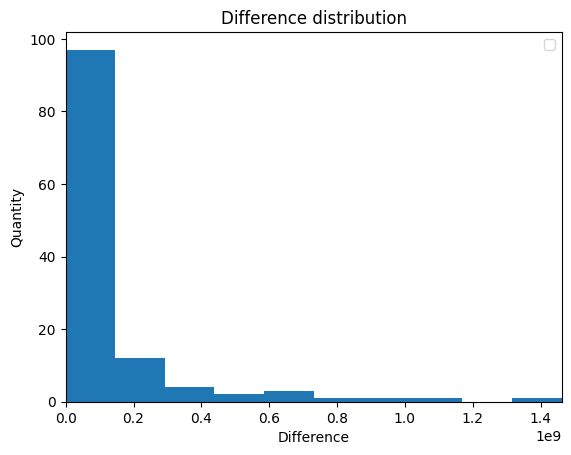

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


# Create a KDE plot
colors = ["purple", "blue", "red", "green", "black", "orange", "magenta"]

#sns.kdeplot(values, color=colors[0])
plt.hist(new_diff_df['Least difference'])

plt.xlim([0, max(values)])

# Customize the plot (optional)
plt.legend()
plt.xlabel('Difference')
plt.ylabel('Quantity')
plt.title('Difference distribution')
plt.show()

In [ ]:
valid = new_diff_df.loc[(new_diff_df['Least difference'] != -1)]

In [ ]:
valid.shape[0]

121

In [ ]:
rows = []
for thr in [pow(10, i) for i in [1, 2, 3, 4, 5, 6, 7, 8, 9]]:
    below =  valid.loc[(valid['Least difference'] < thr) & (valid['Least difference'] != -1)].shape[0]
    print(f"below {thr} #: {below}")
    print(f"below {thr} % {below / valid.shape[0] * 100}\n")
    rows.append([f"< {thr}", below, below / valid.shape[0] * 100])

below 10 #: 31
below 10 % 25.6198347107438

below 100 #: 31
below 100 % 25.6198347107438

below 1000 #: 32
below 1000 % 26.446280991735538

below 10000 #: 34
below 10000 % 28.09917355371901

below 100000 #: 35
below 100000 % 28.92561983471074

below 1000000 #: 47
below 1000000 % 38.84297520661157

below 10000000 #: 59
below 10000000 % 48.760330578512395

below 100000000 #: 91
below 100000000 % 75.20661157024794

below 1000000000 #: 119
below 1000000000 % 98.34710743801654



In [ ]:
t = pd.DataFrame(rows).transpose()
t.columns = t.iloc[0]
t = t.drop(0)
t[''] = ['#', "%"]
t = t[[""] + list(t.columns[0:-1])]
t = t.rename(columns={"< 1000": "<1k", "< 10000": "<10k",	"< 100000":	"<100k", "< 1000000": "< 1M",	"< 10000000": "< 10M",	"< 100000000": "<100M", "< 1000000000": "< 1G"})
t

,,< 10,< 100,<1k,<10k,<100k,< 1M,< 10M,<100M,< 1G
1,#,31,31,32,34,35,47,59,91,119
2,%,25.619835,25.619835,26.446281,28.099174,28.92562,38.842975,48.760331,75.206612,98.347107


In [ ]:
len(to_print_2)

116

In [ ]:
# # save these values

# # Create an ExcelWriter object
# writer = pd.ExcelWriter('All matches - Investments v3 - with difference in amounts.xlsx', engine='xlsxwriter')

# for i in range(len(to_print_2)):
#     # Write the first DataFrame to a specific sheet name and starting row
#     df1 = pd.DataFrame(to_print_2[i][0]).transpose()[aid_columns_to_print[0:10] + ["Amount (Nominal USD)"] + aid_columns_to_print[10:] ]
#     df1.to_excel(writer, sheet_name='AidData row ' + str(to_print_2[i][2]), startrow=0, index=False)

#     # Write the second DataFrame to the same sheet but starting from a new row below the first DataFrame
#     startrow_for_df2 = len(df1) + 2  # Add 2 for spacing between DataFrames
#     #df2 = to_print[i][1][printing_cols]
#     if to_print_2[i][1].shape[0] == 0:
#         continue
#     df2 = to_print_2[i][1][columns_cofi_to_print[0:9] + ["difference"] + columns_cofi_to_print[9:]]
#     df2.to_excel(writer, sheet_name='AidData row ' + str(to_print_2[i][2]), startrow=startrow_for_df2, index=False)

#     startrow_for_df3 = len(df1) + 2 + len(df2) + 2
#     df3 = pd.DataFrame([to_print_2[i][3]], columns=['Difference'])
#     df3.to_excel(writer, sheet_name='AidData row ' + str(to_print_2[i][2]), startrow=startrow_for_df3, index=False)

# # Save the Excel file
# writer.close()

#### Check how many rows do have multiple matches in COFI

In [ ]:
len([x for x in to_print_2 if x[1].shape[0] > 1]) + len([x for x in to_print_2_special if x[1].shape[0] > 1])

25

#### Get all the IDs in COFI that are not matched with any value in COFI

In [ ]:
len(to_print_2) + len(to_print_2_special)

122

In [ ]:
to_print_2_special[0][1]['unique_id'].to_list()

['IDN2021012']

In [ ]:
cofi_ids_investment = []
for i in range(len(to_print_2)):
    cofi_ids_investment.extend(to_print_2[i][1]['unique_id'].to_list())

for i in range(len(to_print_2_special)):
    cofi_ids_investment.extend(to_print_2_special[i][1]['unique_id'].to_list())

In [ ]:
cofi_ids_investment_list = list(set(cofi_ids_investment))
cofi_ids_investment_list.sort()

In [ ]:
pd.DataFrame(cofi_ids_investment_list, columns=['Matched in investment']).to_excel("COFI - matched in AidData investment.xlsx")

In [ ]:
not_matched_investment = []
for cofi_id in set(cofi['unique_id'].to_list()):
    if cofi_id not in cofi_ids_investment_list:
        not_matched_investment.append(cofi_id)

In [ ]:
not_matched_investment_list = list(set(not_matched_investment))
not_matched_investment_list.sort()

In [ ]:
pd.DataFrame(not_matched_investment_list, columns=['Not matched in investment']).to_excel("COFI - not matched in AidData investment.xlsx")

In [ ]:
print(set(not_matched_investment_list) & set(cofi_ids_investment_list) == set())
print(len(not_matched_investment_list) + len(cofi_ids_investment_list) == len(cofi))

True
True


In [ ]:
len(matched_pp_list)

155

In [ ]:
len(cofi_ids_investment_list)

92

#### Save all results

We print both the entries that have one bank in "Funding Agencies" and those that have multiples in one file.

In [ ]:
# Create an ExcelWriter object
writer = pd.ExcelWriter('All matches - Investments v3.xlsx', engine='xlsxwriter')

for i in range(len(to_print_2)):
    # Write the first DataFrame to a specific sheet name and starting row
    df1 = pd.DataFrame(to_print_2[i][0]).transpose()[aid_columns_to_print[0:11] + ["Amount (Nominal USD)"] + aid_columns_to_print[11:] ]
    df1.to_excel(writer, sheet_name='AidData ID ' + str(to_print_2[i][2]), startrow=0, index=False)

    # Write the second DataFrame to the same sheet but starting from a new row below the first DataFrame
    startrow_for_df2 = len(df1) + 2  # Add 2 for spacing between DataFrames
    #df2 = to_print[i][1][printing_cols]
    if to_print_2[i][1].shape[0] == 0:
        print("hello")
        continue
    df2 = to_print_2[i][1][columns_cofi_to_print[0:10] + ["difference"] + columns_cofi_to_print[10:]]
    df2.to_excel(writer, sheet_name='AidData ID ' + str(to_print_2[i][2]), startrow=startrow_for_df2, index=False)

    startrow_for_df3 = len(df1) + 2 + len(df2) + 2
    df3 = pd.DataFrame([to_print_2[i][3]], columns=['Least difference'])
    df3.to_excel(writer, sheet_name='AidData ID ' + str(to_print_2[i][2]), startrow=startrow_for_df3, index=False)

to_print_2 = to_print_2_special

for i in range(len(to_print_2)):
    # Write the first DataFrame to a specific sheet name and starting row
    df1 = pd.DataFrame(to_print_2[i][0]).transpose()[aid_columns_to_print[0:11] + ["Amount (Nominal USD)"] + aid_columns_to_print[11:]  ]
    df1.to_excel(writer, sheet_name='AidData ID ' + str(to_print_2[i][2]), startrow=0, index=False)

    # Write the second DataFrame to the same sheet but starting from a new row below the first DataFrame
    startrow_for_df2 = len(df1) + 2  # Add 2 for spacing between DataFrames
    #df2 = to_print[i][1][printing_cols]
    if to_print_2[i][1].shape[0] == 0:
        continue
    df2 = to_print_2[i][1][columns_cofi_to_print[0:10] + ["difference", "differences per bank"] + columns_cofi_to_print[10:]]
    df2.to_excel(writer, sheet_name='AidData ID ' + str(to_print_2[i][2]), startrow=startrow_for_df2, index=False)

    startrow_for_df3 = len(df1) + 2 + len(df2) + 2
    df3 = pd.DataFrame([to_print_2[i][3]], columns=['Least difference'])
    df3.to_excel(writer, sheet_name='AidData ID ' + str(to_print_2[i][2]), startrow=startrow_for_df3, index=False)

# Save the Excel file
writer.close()

In [ ]:
# check
temp= pd.read_excel("All matches - Investments v3.xlsx", sheet_name=None)

In [ ]:
len(temp)

122

Note: in COFI there are some results that have explicitly 0, so when we do the difference these are included (the difference is the value in Aid - 0 = the value in Aid): I thought this would distort the analysis of the differences but that doesn't happen, the distribution of the values (below "< 10", "< 100", etc.) isn't affected.